# Note:
Some part of code including PCA and ICA plot Build were adopted from another source.
https://github.com/kylewest520/CS-7641---Machine-Learning/blob/e4e628f88ac832ebc090b74212c1a1f2b7673d99/Assignment%203%20Unsupervised%20Learning/CS%207641%20HW3%20Code.py#L136

In [437]:
import os
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
import mlrose_hiive
import time
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
seed = 22955
import string

In [438]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')

# Reading Data

## Adult Data

In [439]:
df_income = pd.read_csv('../Data/Adult/income.csv', header= None)
df_income.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
                       'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
df_income['workclass']= df_income['workclass'].str.strip()
df_income['education']= df_income['education'].str.strip()
df_income['marital-status']= df_income['marital-status'].str.strip()
df_income['occupation']= df_income['occupation'].str.strip()
df_income['relationship']= df_income['relationship'].str.strip()
df_income['race']= df_income['race'].str.strip()
df_income['sex']= df_income['sex'].str.strip()
df_income['native-country']= df_income['native-country'].str.strip()
df_income['income']= df_income['income'].str.strip()

In [440]:
df_income = df_income.fillna("Unknown")
df_income['age_group'] = pd.cut(df_income.age, bins=[15,20,30,40,50,60,70,80,90])
df_income['education'] = df_income['education'].replace(['1st-4th', '5th-6th', '7th-8th','9th','10th','11th','12th', 'Preschool'], 'Some School')
df_income['marital-status'] = df_income['marital-status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married')
df_income['marital-status'] = df_income['marital-status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed'], 'Not Married')
df_income.loc[df_income['native-country']!='United-States', 'native-country'] = 'Not US'
df_income.loc[df_income['native-country']=='United-States', 'native-country'] = 'US'
df_income['capital-gain-cat'] = 0
df_income.loc[df_income['capital-gain']>0, 'capital-gain-cat'] = 1
df_income['capital-gain-cat'] =df_income['capital-gain-cat'].astype('category')

df_income['capital-loss-cat'] = 0
df_income.loc[df_income['capital-loss']>0, 'capital-loss-cat'] = 1
df_income['capital-loss-cat'] =df_income['capital-loss-cat'].astype('category')


df_income['hours-cat'] = 0
df_income.loc[df_income['hours-per-week']==40, 'hours-cat'] = '40'
df_income.loc[df_income['hours-per-week']>40, 'hours-cat'] = '>40'
df_income.loc[df_income['hours-per-week']<40, 'hours-cat'] = '<40'

df_income = df_income[['workclass', 'fnlwgt', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'native-country','income', 'age_group', 'capital-gain-cat', 'capital-loss-cat',
       'hours-cat']]

### one-hot encoding and normalization

In [441]:
cot_col = ['workclass','education', 'marital-status', 'occupation','relationship', 'race', 'sex',
           'native-country', 'age_group', 'capital-gain-cat','capital-loss-cat', 'hours-cat']
df_cat = df_income[cot_col]
df_cat = pd.get_dummies(df_cat).astype('category')

numric_col = ['fnlwgt','capital-gain','capital-loss']
df_numeric = df_income[numric_col]
df_numeric = df_numeric.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

df_income_final = pd.concat([df_cat,df_numeric,df_income['income']],axis=1)

df_income_final.loc[df_income_final['income']=='>50K', 'income']=1
df_income_final.loc[df_income_final['income']=='<=50K', 'income']=0
df_income_final['income'] = df_income_final['income'].astype('category')

### train_test split

In [442]:
df_income_final = df_income_final.sample(n=2000, replace=False, random_state=20)
X_adult = df_income_final.drop('income', axis=1).values
y_adult = df_income_final['income'].values
RU = RandomUnderSampler(random_state=20, sampling_strategy = 'majority')
X_RU_adult, y_RU_adult = RU.fit_resample(X_adult, y_adult)
X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(X_RU_adult, y_RU_adult, test_size=0.2, random_state=20)



# X_train_RU, y_train_RU = RU.fit_resample(X_train, y_train)

print("ratio of >50 in data: ", y_train_adult.astype('int').sum()/len(y_train_adult))
# print("ratio of >50 in RandomUnderSampler balanced data: ", y_train_RU.astype('int').sum()/len(y_train_RU))

print(len(y_train_adult))
# print(len(y_train_RU))

ratio of >50 in data:  0.5151098901098901
728


## Leterr Recognition Data

In [443]:
df_Lrecog = pd.read_csv('../Data/Letter Recognition/letter-recognition.data.csv')
df_Lrecog_final = df_Lrecog.sample(n=2000, replace=False, random_state=20)
df_Lrecog_final = df_Lrecog
X_Lrecog = df_Lrecog_final.drop('Letter', axis=1).values
y_Lrecog = df_Lrecog_final['Letter'].values

# Clustering

## K-means

In [444]:
def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target 
    return pred

def kmeans_plot(X,y,title):
    range_n_clusters = np.arange(3,100,5)
    inertia = []
    distortions = []
    f1_scores=[]
    sil_scores=[]
    for n_clusters in range_n_clusters:

        k_means_model = KMeans(n_clusters=n_clusters, random_state=22955).fit(X)
        k_means_model.fit(X)
        inertia.append(k_means_model.inertia_)
        distortions.append(sum(np.min(cdist(X, k_means_model.cluster_centers_,
                                            'euclidean'), axis=1)) / X.shape[0])

        y_pred = cluster_predictions(y,k_means_model.labels_)
        f1_scores.append(f1_score(y, y_pred, average='weighted'))
        sil_scores.append(sil_score(X, k_means_model.labels_))

    inertia = np.array(inertia)
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    
    ax[0,0].plot(range_n_clusters,inertia)
    ax[0,0].set_xlabel('K Value')
    ax[0,0].set_ylabel('Inertia')
    ax[0,0].set_title('Inertia')
    ax[0,0].grid()


    ax[0,1].plot(range_n_clusters,distortions)
    ax[0,1].set_xlabel('K Value')
    ax[0,1].set_ylabel('Distortion')
    ax[0,1].set_title('Euclidean Distortion')
    ax[0,1].grid()

    
    ax[1,0].plot(range_n_clusters,f1_scores)
    ax[1,0].set_xlabel('K Value')
    ax[1,0].set_ylabel('f1-score')
    ax[1,0].set_title('f1_score')
    ax[1,0].grid()
    
    ax[1,1].plot(range_n_clusters,sil_scores)
    ax[1,1].set_xlabel('K Value')
    ax[1,1].set_ylabel('sil_score')
    ax[1,1].set_title('sil_score')
    ax[1,1].grid()
    
    fig.suptitle('Kmeans method {} dataset'.format(title), fontsize=20)
    fig.savefig('Kmeans_{}.jpg'.format(title), y=1.2)
    plt.show()
    return inertia,distortions,f1_scores,sil_scores
    



### Letter Recognition

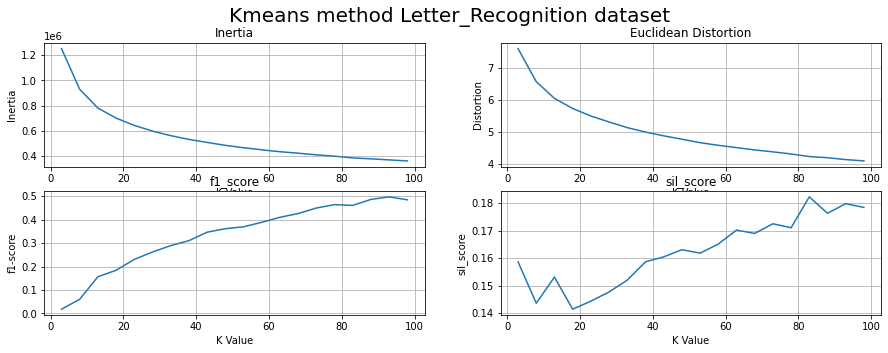

In [445]:
inertia_km_lrecog,distortions_km_lrecog,f1_scores_km_lrecog,sil_scores_km_lrecog = kmeans_plot(X_Lrecog,y_Lrecog,'Letter_Recognition')


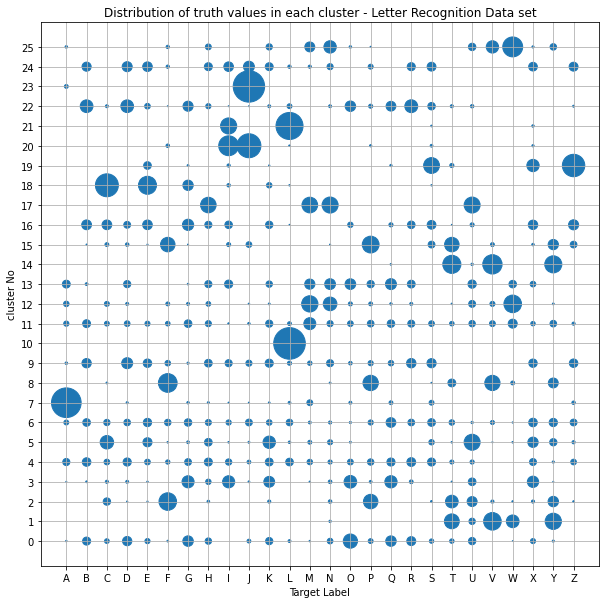

In [446]:
n_clusters = 26
k_means_model = KMeans(n_clusters=n_clusters, random_state=22955).fit(X_Lrecog)
df= pd.DataFrame()
df['y'] = df_Lrecog_final['Letter'].astype('category').cat.codes
df['y_pred'] = k_means_model.fit_predict(X_Lrecog)
new_df = df.groupby(['y','y_pred']).size().reset_index()
new_df['y'] = new_df['y'].astype('category').cat.codes
new_df['y_pred'] = new_df['y_pred'].astype('category').cat.codes
new_df['sum_y']= new_df.groupby('y_pred')[0].transform('sum')
new_df['size_normed'] = new_df[0]/new_df['sum_y']

plt.figure(figsize=(10, 10))
plt.scatter(new_df['y'],new_df['y_pred'],s=new_df['size_normed']*1000)
plt.xticks(np.arange(0, 26), list(string.ascii_uppercase))
plt.yticks(np.arange(0, n_clusters))
plt.ylabel('cluster No')
plt.xlabel('Target Label')
plt.title("Distribution of truth values in each cluster - Letter Recognition Data set")
plt.grid()
plt.show()

### Adult

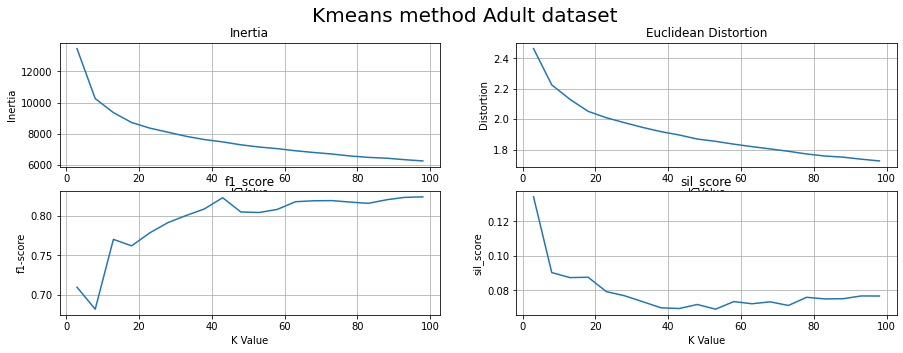

In [447]:
inertia_km_adult,distortions_km_adult,f1_scores_km_adult,sil_scores_km_adult = kmeans_plot(X_adult,y_adult,'Adult')

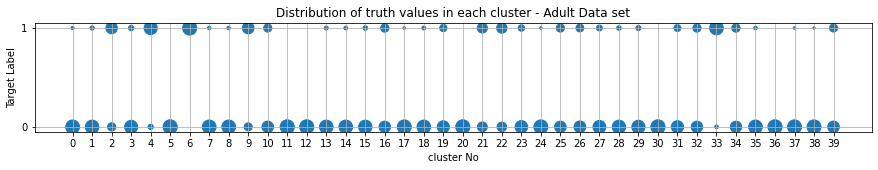

In [448]:
n_clusters = 40
k_means_model = KMeans(n_clusters=n_clusters, random_state=22955).fit(X_adult)
df= pd.DataFrame()
df['y'] = df_income_final['income'].astype('category').cat.codes
df['y_pred'] = k_means_model.fit_predict(X_adult)
new_df = df.groupby(['y','y_pred']).size().reset_index()
new_df['y'] = new_df['y'].astype('category').cat.codes
new_df['y_pred'] = new_df['y_pred'].astype('category').cat.codes
new_df['sum_y']= new_df.groupby('y_pred')[0].transform('sum')
new_df['size_normed'] = new_df[0]/new_df['sum_y']

plt.figure(figsize=(15, 2))
plt.scatter(new_df['y_pred'],new_df['y'],s=new_df['size_normed']*200)
plt.yticks(np.arange(0, 2))
plt.xticks(np.arange(0, n_clusters))
plt.xlabel('cluster No')
plt.ylabel('Target Label')
plt.title("Distribution of truth values in each cluster - Adult Data set")
plt.grid()
plt.show()

## Expectation Maximization

In [449]:
from sklearn.mixture import GaussianMixture as EM
def EM_plot(X,y,title):
    n_components = list(np.arange(2,100,5))
    f1_scores=[]
    sil_scores=[]
    aic_scores = []
    bic_scores = []
    for n in n_components:
        Em_model = EM(n_components=n,covariance_type='diag',random_state=22955).fit(X)       
        y_labels = Em_model.predict(X)

        y_pred = cluster_predictions(y,y_labels)
        f1_scores.append(f1_score(y, y_pred, average='weighted'))
        sil_scores.append(sil_score(X, y_labels))
        aic_scores.append(Em_model.aic(X))
        bic_scores.append(Em_model.bic(X))
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0,0].plot(n_components,aic_scores)
    ax[0,0].set_xlabel('n_components')
    ax[0,0].set_ylabel('Akaike information')
    ax[0,0].set_title('Akaike information')
    ax[0,0].grid()


    ax[0,1].plot(n_components,bic_scores)
    ax[0,1].set_xlabel('n_components')
    ax[0,1].set_ylabel('Bayesian information')
    ax[0,1].set_title('Bayesian information')
    ax[0,1].grid()

    
    ax[1,0].plot(n_components,f1_scores)
    ax[1,0].set_xlabel('K Value')
    ax[1,0].set_ylabel('f1-score')
    ax[1,0].set_title('f1_score')
    ax[1,0].grid()
    
    ax[1,1].plot(n_components,sil_scores)
    ax[1,1].set_xlabel('K Value')
    ax[1,1].set_ylabel('sil_score')
    ax[1,1].set_title('sil_score')
    ax[1,1].grid()
    
    fig.suptitle('EM method {} dataset'.format(title), fontsize=20)
    fig.savefig('EM_{}.jpg'.format(title), y=1.2)
    plt.show()        
    return aic_scores, bic_scores,  f1_scores, sil_scores

### Letter Recognition

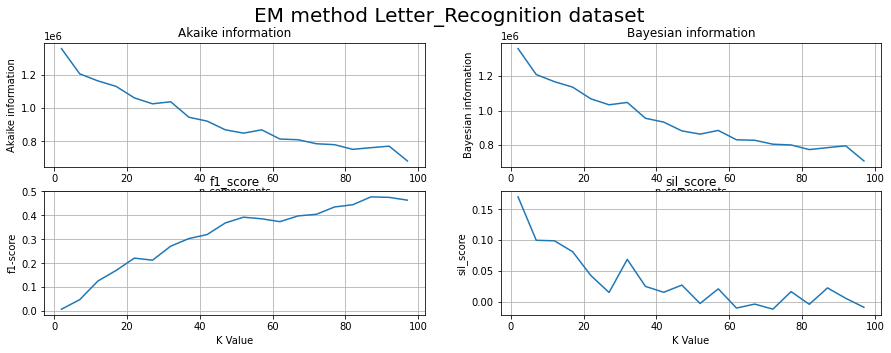

In [450]:
aic_scores_em_lrcog, bic_scores_em_lrcog,  f1_scores_em_lrcog, sil_scores_em_lrcog = EM_plot(X_Lrecog,y_Lrecog,'Letter_Recognition')

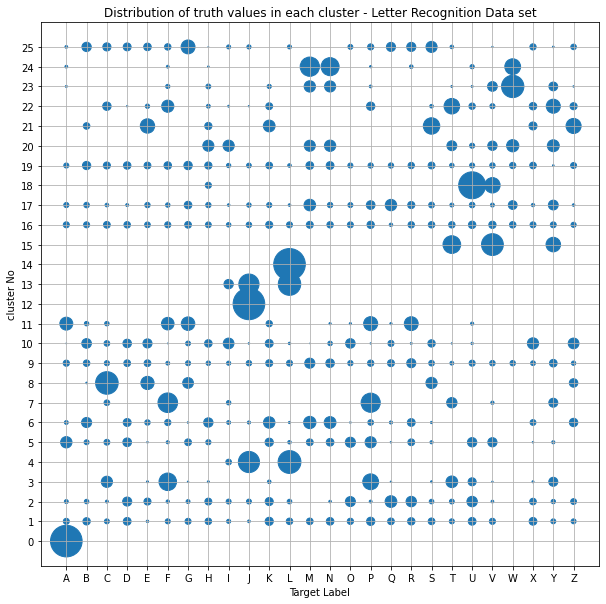

In [451]:
n_components = 26
Em_model = EM(n_components=n_components,covariance_type='diag',random_state=22955).fit(X_Lrecog)
df= pd.DataFrame()
df['y'] = df_Lrecog_final['Letter'].astype('category').cat.codes
df['y_pred'] = Em_model.fit_predict(X_Lrecog)
new_df = df.groupby(['y','y_pred']).size().reset_index()
new_df['y'] = new_df['y'].astype('category').cat.codes
new_df['y_pred'] = new_df['y_pred'].astype('category').cat.codes
new_df['sum_y']= new_df.groupby('y_pred')[0].transform('sum')
new_df['size_normed'] = new_df[0]/new_df['sum_y']

plt.figure(figsize=(10, 10))
plt.scatter(new_df['y'],new_df['y_pred'],s=new_df['size_normed']*1000)
plt.xticks(np.arange(0, 26), list(string.ascii_uppercase))
plt.yticks(np.arange(0, n_components))
plt.ylabel('cluster No')
plt.xlabel('Target Label')
plt.title("Distribution of truth values in each cluster - Letter Recognition Data set")
plt.grid()
plt.show()

### Adult

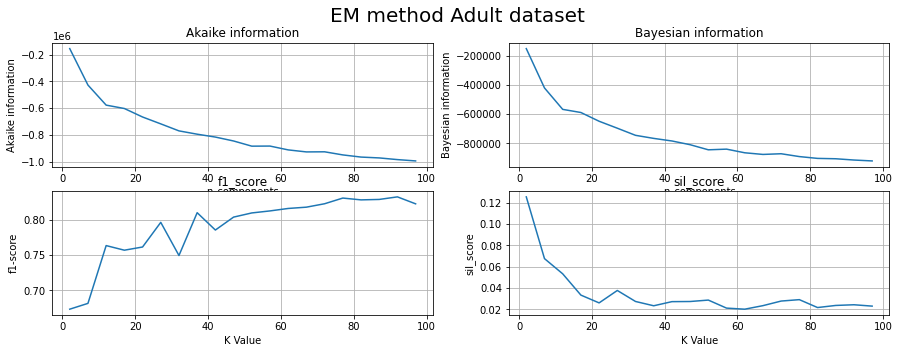

In [452]:
aic_scores_em_adult, bic_scores_em_adult,  f1_scores_em_adult, sil_scores_em_adult = EM_plot(X_adult,y_adult,'Adult')

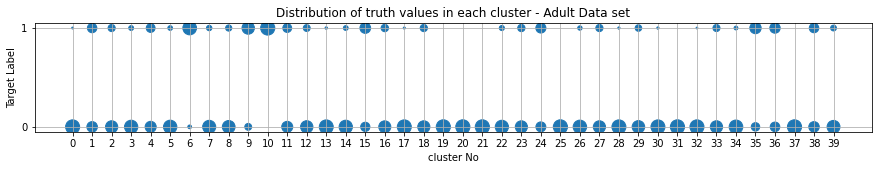

In [453]:
n_components = 40
Em_model = EM(n_components=n_components,covariance_type='diag',random_state=22955).fit(X_adult)
df= pd.DataFrame()
df['y'] = df_income_final['income'].astype('category').cat.codes
df['y_pred'] = Em_model.fit_predict(X_adult)
new_df = df.groupby(['y','y_pred']).size().reset_index()
new_df['y'] = new_df['y'].astype('category').cat.codes
new_df['y_pred'] = new_df['y_pred'].astype('category').cat.codes
new_df['sum_y']= new_df.groupby('y_pred')[0].transform('sum')
new_df['size_normed'] = new_df[0]/new_df['sum_y']

plt.figure(figsize=(15, 2))
plt.scatter(new_df['y_pred'],new_df['y'],s=new_df['size_normed']*200)
plt.yticks(np.arange(0, 2))
plt.xticks(np.arange(0, n_components))
plt.xlabel('cluster No')
plt.ylabel('Target Label')
plt.title("Distribution of truth values in each cluster - Adult Data set")
plt.grid()
plt.show()

## Dimensionality Reduction

### PCA

In [454]:
from sklearn.decomposition import PCA, FastICA as ICA
def build_PCA(X,y,title):
    
    pca = PCA(random_state=22955).fit(X)
    cum_var_explained = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    A = list(range(len(pca.explained_variance_ratio_)))
    ax1.plot(cum_var_explained, 'black')
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Cumulative Explained Variance Ratio')
    ax1.tick_params('y')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(pca.singular_values_, 'r-')
    ax2.set_ylabel('Eigenvalues', color='r')
    ax2.tick_params('y', colors='r')
    plt.grid()

    plt.title("PCA: "+ title)
    plt.show()

#### Letter Recognition

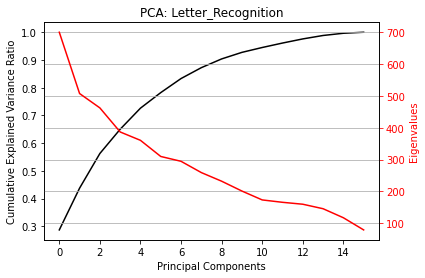

In [455]:
build_PCA(X_Lrecog,y_Lrecog,'Letter_Recognition')

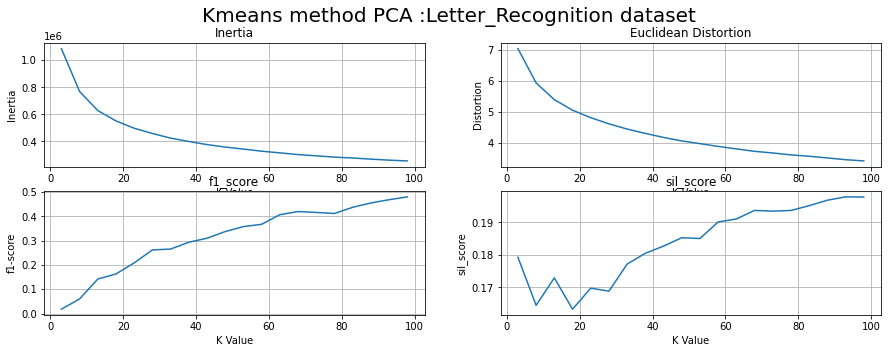

In [456]:
pca=PCA(0.9,random_state=22955)
X_Lrecog_DR=pca.fit_transform(X_Lrecog) 
inertia_km_lrecog_PCA,distortions_km_lrecog_PCA,f1_scores_km_lrecog_PCA,sil_scores_km_lrecog_PCA = kmeans_plot(X_Lrecog_DR,y_Lrecog,'PCA :Letter_Recognition')


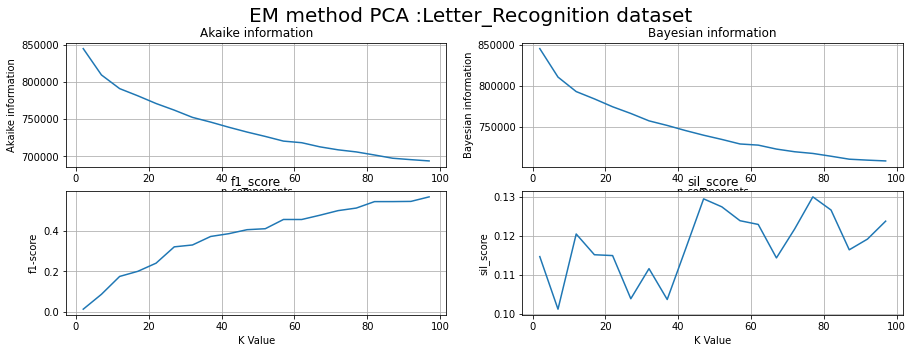

In [457]:
aic_scores_em_lrcog_PCA, bic_scores_em_lrcog_PCA, f1_scores_em_lrcog_PCA, sil_scores_em_lrcog_PCA = EM_plot(X_Lrecog_DR,y_Lrecog,'PCA :Letter_Recognition')

#### Adult

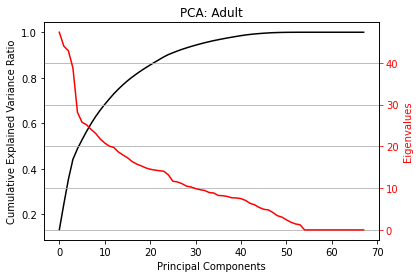

In [458]:
build_PCA(X_adult,y_adult,'Adult')

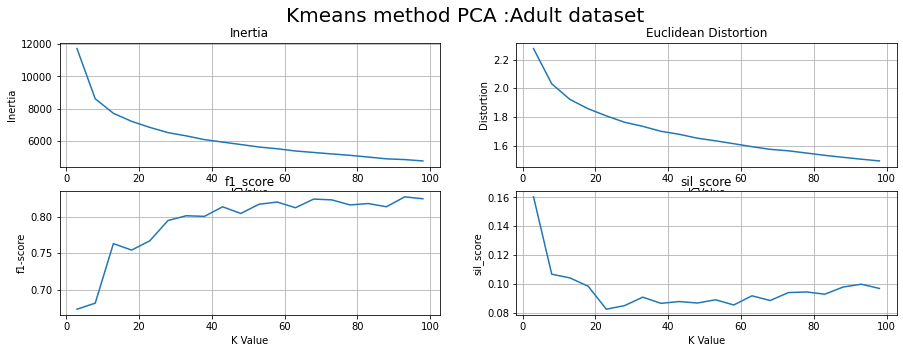

In [459]:
pca=PCA(0.9,random_state=22955)
X_adult_DR=pca.fit_transform(X_adult) 
inertia_km_adult_PCA,distortions_km_adult_PCA,f1_scores_km_adult_PCA,sil_scores_km_adult_PCA = kmeans_plot(X_adult_DR,y_adult,'PCA :Adult')

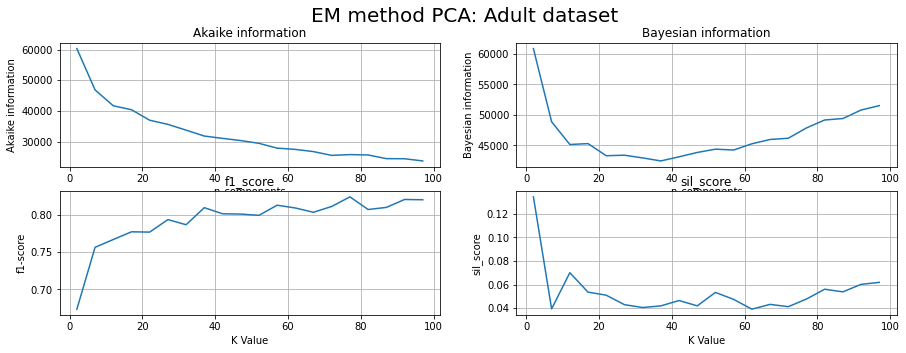

In [460]:
aic_scores_em_adult_PCA, bic_scores_em_adult_PCA,  f1_scores_em_adult_PCA, sil_scores_em_adult_PCA = EM_plot(X_adult_DR,y_adult,'PCA: Adult')

### ICA

In [461]:
def build_ICA(X,y,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=22955, whiten="arbitrary-variance")
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt)
    plt.show()

#### Letter Recognition

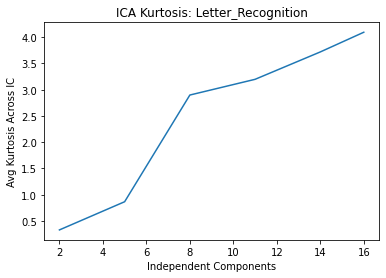

In [462]:
build_ICA(X_Lrecog,y_Lrecog,'Letter_Recognition')

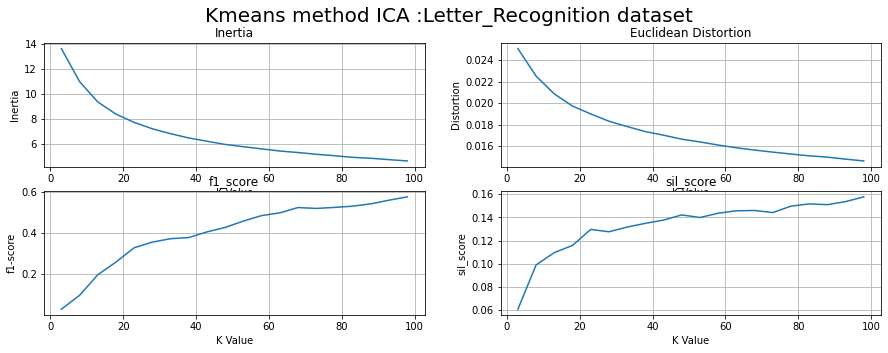

In [463]:
ica=ICA(random_state=22955, n_components=15)
X_Lrecog_DR=ica.fit_transform(X_Lrecog) 
inertia_km_lrecog_ICA,distortions_km_lrecog_ICA,f1_scores_km_lrecog_ICA,sil_scores_km_lrecog_ICA = kmeans_plot(X_Lrecog_DR,y_Lrecog,'ICA :Letter_Recognition')


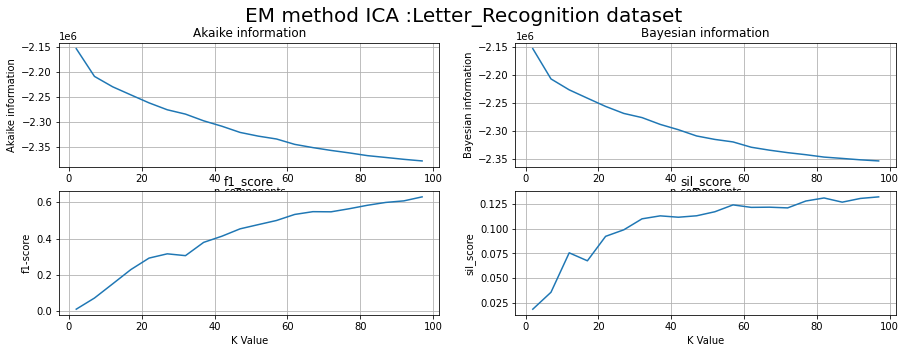

In [464]:
aic_scores_em_lrcog_ICA, bic_scores_em_lrcog_ICA, f1_scores_em_lrcog_ICA, sil_scores_em_lrcog_ICA = EM_plot(X_Lrecog_DR,y_Lrecog,'ICA :Letter_Recognition')

#### Adult

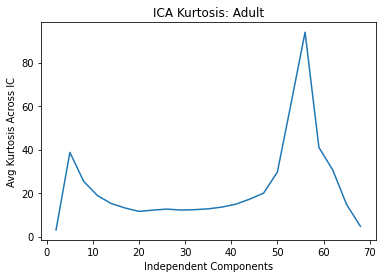

In [465]:
build_ICA(X_adult,y_adult,'Adult')

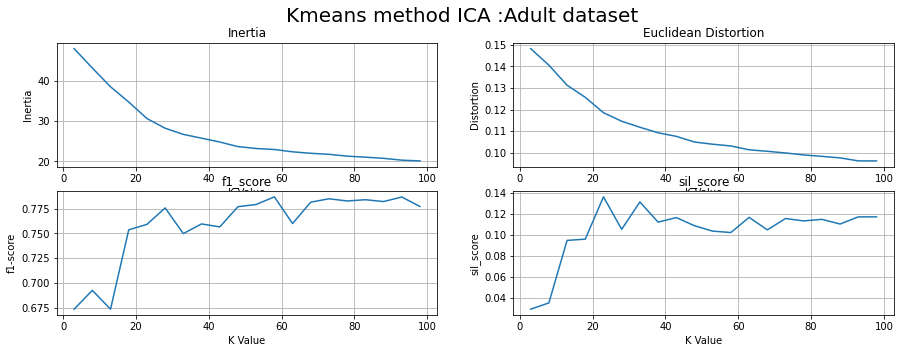

In [466]:
ica=ICA(random_state=22955, n_components=50)
X_adult_DR=ica.fit_transform(X_adult) 
inertia_km_adult_ICA,distortions_km_adult_ICA,f1_scores_km_adult_ICA,sil_scores_km_adult_ICA = kmeans_plot(X_adult_DR,y_adult,'ICA :Adult')

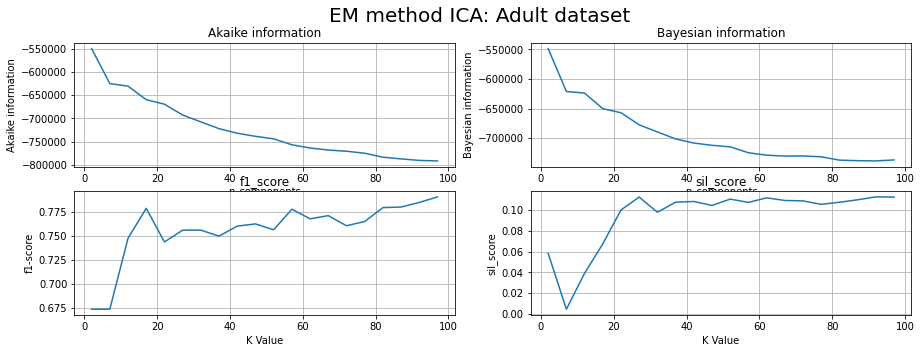

In [467]:
aic_scores_em_adult_ICA, bic_scores_em_adult_ICA,  f1_scores_em_adult_ICA, sil_scores_em_adult_ICA = EM_plot(X_adult_DR,y_adult,'ICA: Adult')

### RCA

#### Letter Recognition

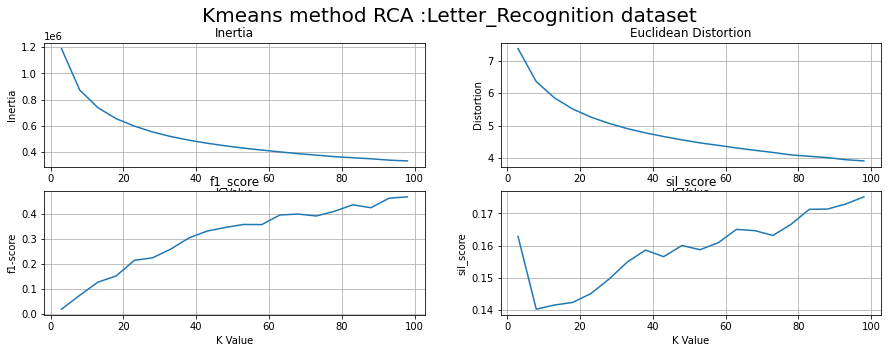

In [468]:
r
ca=RCA(random_state=22955, n_components=15)
X_Lrecog_DR=rca.fit_transform(X_Lrecog) 
inertia_km_lrecog_RCA,distortions_km_lrecog_RCA,f1_scores_km_lrecog_RCA,sil_scores_km_lrecog_RCA = kmeans_plot(X_Lrecog_DR,y_Lrecog,'RCA :Letter_Recognition')


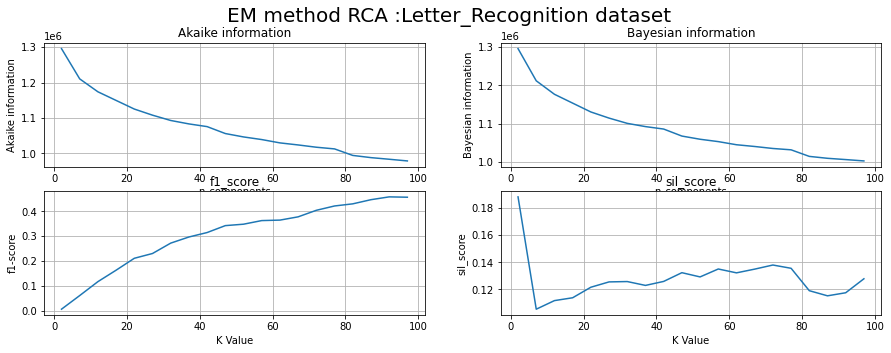

In [469]:
aic_scores_em_lrcog_RCA, bic_scores_em_lrcog_RCA, f1_scores_em_lrcog_RCA, sil_scores_em_lrcog_RCA = EM_plot(X_Lrecog_DR,y_Lrecog,'RCA :Letter_Recognition')

#### Adult

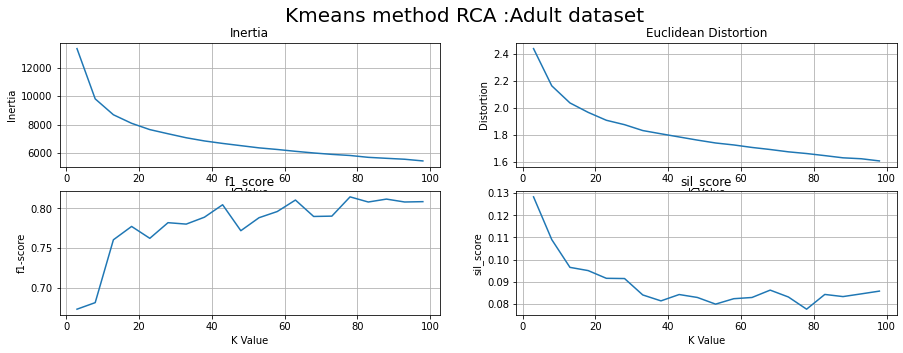

In [470]:
rca=RCA(random_state=22955, n_components=50)
X_adult_DR=rca.fit_transform(X_adult) 
inertia_km_adult_RCA,distortions_km_adult_RCA,f1_scores_km_adult_RCA,sil_scores_km_adult_RCA = kmeans_plot(X_adult_DR,y_adult,'RCA :Adult')

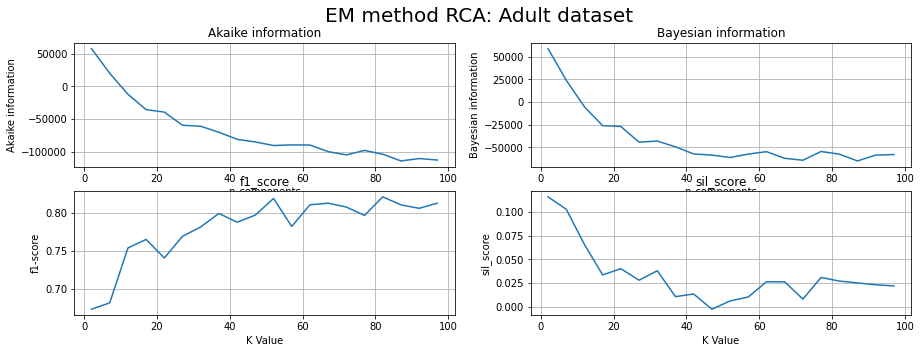

In [471]:
aic_scores_em_adult_RCA, bic_scores_em_adult_RCA,  f1_scores_em_adult_RCA, sil_scores_em_adult_RCA = EM_plot(X_adult_DR,y_adult,'RCA: Adult')

### ISOmap

#### Letter_Recognition

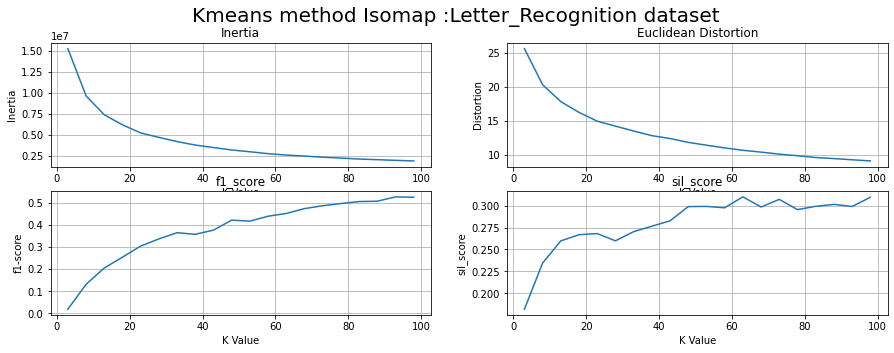

In [472]:
from sklearn.manifold import Isomap
isomap=Isomap(n_components=15)
X_Lrecog_DR=isomap.fit_transform(X_Lrecog) 
inertia_km_lrecog_isomap,distortions_km_lrecog_isomap,f1_scores_km_lrecog_isomap,sil_scores_km_lrecog_isomap = kmeans_plot(X_Lrecog_DR,y_Lrecog,'Isomap :Letter_Recognition')



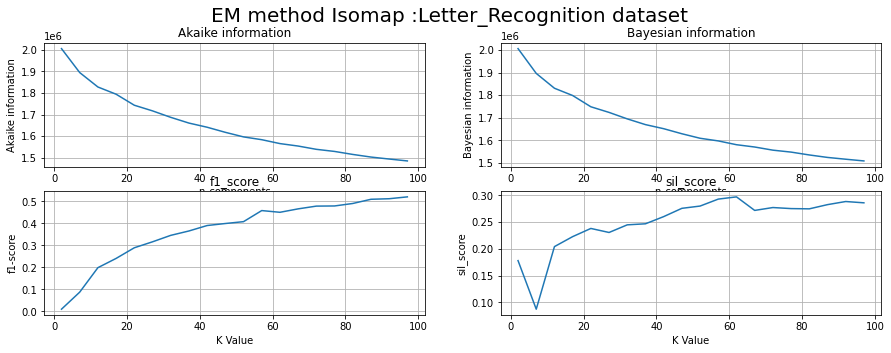

In [473]:
aic_scores_em_lrcog_isomap, bic_scores_em_lrcog_isomap, f1_scores_em_lrcog_isomap, sil_scores_em_lrcog_isomap = EM_plot(X_Lrecog_DR,y_Lrecog,'Isomap :Letter_Recognition')

#### Adult

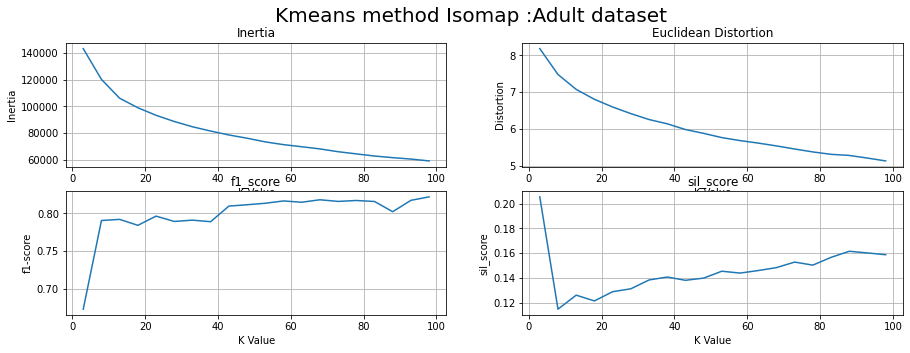

In [474]:
isomap=Isomap(n_components=50)
X_adult_DR=isomap.fit_transform(X_adult) 
inertia_km_adult_isomap,distortions_km_adult_isomap,f1_scores_km_adult_isomap,sil_scores_km_adult_isomap = kmeans_plot(X_adult_DR,y_adult,'Isomap :Adult')

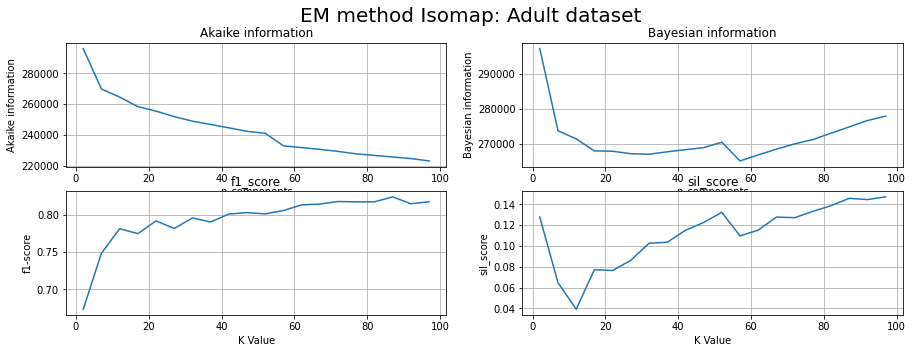

In [475]:
aic_scores_em_adult_isomap, bic_scores_em_adult_isomap,  f1_scores_em_adult_isomap, sil_scores_em_adult_isomap = EM_plot(X_adult_DR,y_adult,'Isomap: Adult')

### Plot Comparison

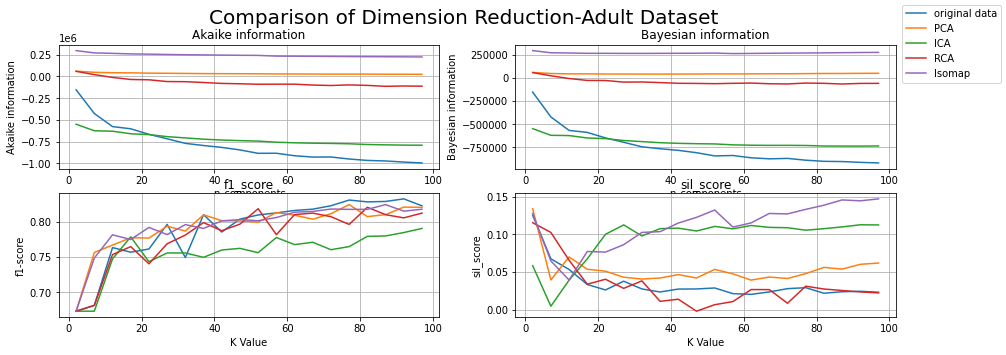

In [476]:
#EM Adult
n_components = list(np.arange(2,100,5))
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0,0].plot(n_components,aic_scores_em_adult, label='original data')
ax[0,0].plot(n_components,aic_scores_em_adult_PCA, label='PCA')
ax[0,0].plot(n_components,aic_scores_em_adult_ICA, label='ICA')
ax[0,0].plot(n_components,aic_scores_em_adult_RCA, label='RCA')
ax[0,0].plot(n_components,aic_scores_em_adult_isomap, label='Isomap')
ax[0,0].set_xlabel('n_components')
ax[0,0].set_ylabel('Akaike information')
ax[0,0].set_title('Akaike information')
ax[0,0].grid()


ax[0,1].plot(n_components,bic_scores_em_adult)
ax[0,1].plot(n_components,bic_scores_em_adult_PCA)
ax[0,1].plot(n_components,bic_scores_em_adult_ICA)
ax[0,1].plot(n_components,bic_scores_em_adult_RCA)
ax[0,1].plot(n_components,bic_scores_em_adult_isomap)
ax[0,1].set_xlabel('n_components')
ax[0,1].set_ylabel('Bayesian information')
ax[0,1].set_title('Bayesian information')
ax[0,1].grid()


ax[1,0].plot(n_components,f1_scores_em_adult)
ax[1,0].plot(n_components,f1_scores_em_adult_PCA)
ax[1,0].plot(n_components,f1_scores_em_adult_ICA)
ax[1,0].plot(n_components,f1_scores_em_adult_RCA)
ax[1,0].plot(n_components,f1_scores_em_adult_isomap)
ax[1,0].set_xlabel('K Value')
ax[1,0].set_ylabel('f1-score')
ax[1,0].set_title('f1_score')
ax[1,0].grid()

ax[1,1].plot(n_components,sil_scores_em_adult)
ax[1,1].plot(n_components,sil_scores_em_adult_PCA)
ax[1,1].plot(n_components,sil_scores_em_adult_ICA)
ax[1,1].plot(n_components,sil_scores_em_adult_RCA)
ax[1,1].plot(n_components,sil_scores_em_adult_isomap)
ax[1,1].set_xlabel('K Value')
ax[1,1].set_ylabel('sil_score')
ax[1,1].set_title('sil_score')
ax[1,1].grid()
fig.legend()
fig.suptitle('Comparison of Dimension Reduction-Adult Dataset', fontsize=20)
plt.show()   

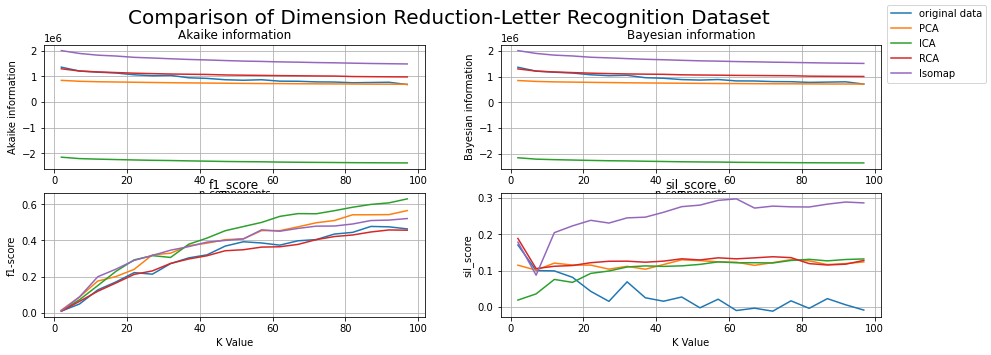

In [477]:
#EM Letter Recognition
n_components = list(np.arange(2,100,5))
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0,0].plot(n_components,aic_scores_em_lrcog, label='original data')
ax[0,0].plot(n_components,aic_scores_em_lrcog_PCA, label='PCA')
ax[0,0].plot(n_components,aic_scores_em_lrcog_ICA, label='ICA')
ax[0,0].plot(n_components,aic_scores_em_lrcog_RCA, label='RCA')
ax[0,0].plot(n_components,aic_scores_em_lrcog_isomap, label='Isomap')
ax[0,0].set_xlabel('n_components')
ax[0,0].set_ylabel('Akaike information')
ax[0,0].set_title('Akaike information')
ax[0,0].grid()


ax[0,1].plot(n_components,bic_scores_em_lrcog)
ax[0,1].plot(n_components,bic_scores_em_lrcog_PCA)
ax[0,1].plot(n_components,bic_scores_em_lrcog_ICA)
ax[0,1].plot(n_components,bic_scores_em_lrcog_RCA)
ax[0,1].plot(n_components,bic_scores_em_lrcog_isomap)
ax[0,1].set_xlabel('n_components')
ax[0,1].set_ylabel('Bayesian information')
ax[0,1].set_title('Bayesian information')
ax[0,1].grid()


ax[1,0].plot(n_components,f1_scores_em_lrcog)
ax[1,0].plot(n_components,f1_scores_em_lrcog_PCA)
ax[1,0].plot(n_components,f1_scores_em_lrcog_ICA)
ax[1,0].plot(n_components,f1_scores_em_lrcog_RCA)
ax[1,0].plot(n_components,f1_scores_em_lrcog_isomap)
ax[1,0].set_xlabel('K Value')
ax[1,0].set_ylabel('f1-score')
ax[1,0].set_title('f1_score')
ax[1,0].grid()

ax[1,1].plot(n_components,sil_scores_em_lrcog)
ax[1,1].plot(n_components,sil_scores_em_lrcog_PCA)
ax[1,1].plot(n_components,sil_scores_em_lrcog_ICA)
ax[1,1].plot(n_components,sil_scores_em_lrcog_RCA)
ax[1,1].plot(n_components,sil_scores_em_lrcog_isomap)
ax[1,1].set_xlabel('K Value')
ax[1,1].set_ylabel('sil_score')
ax[1,1].set_title('sil_score')
ax[1,1].grid()
fig.legend()
fig.suptitle('Comparison of Dimension Reduction-Letter Recognition Dataset', fontsize=20)
plt.show()   

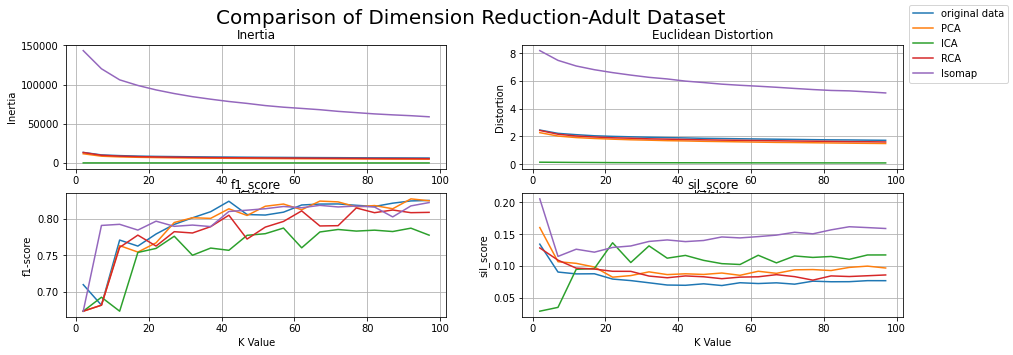

In [478]:
#Kmeans Adult
range_n_clusters = list(np.arange(2,100,5))
fig, ax = plt.subplots(2, 2, figsize=(15, 5))

ax[0,0].plot(range_n_clusters,inertia_km_adult, label='original data')
ax[0,0].plot(range_n_clusters,inertia_km_adult_PCA, label='PCA')
ax[0,0].plot(range_n_clusters,inertia_km_adult_ICA, label='ICA')
ax[0,0].plot(range_n_clusters,inertia_km_adult_RCA, label='RCA')
ax[0,0].plot(range_n_clusters,inertia_km_adult_isomap, label='Isomap')
ax[0,0].set_xlabel('K Value')
ax[0,0].set_ylabel('Inertia')
ax[0,0].set_title('Inertia')
ax[0,0].grid()


ax[0,1].plot(range_n_clusters,distortions_km_adult)
ax[0,1].plot(range_n_clusters,distortions_km_adult_PCA)
ax[0,1].plot(range_n_clusters,distortions_km_adult_ICA)
ax[0,1].plot(range_n_clusters,distortions_km_adult_RCA)
ax[0,1].plot(range_n_clusters,distortions_km_adult_isomap)
ax[0,1].set_xlabel('K Value')
ax[0,1].set_ylabel('Distortion')
ax[0,1].set_title('Euclidean Distortion')
ax[0,1].grid()


ax[1,0].plot(range_n_clusters,f1_scores_km_adult)
ax[1,0].plot(range_n_clusters,f1_scores_km_adult_PCA)
ax[1,0].plot(range_n_clusters,f1_scores_km_adult_ICA)
ax[1,0].plot(range_n_clusters,f1_scores_km_adult_RCA)
ax[1,0].plot(range_n_clusters,f1_scores_km_adult_isomap)
ax[1,0].set_xlabel('K Value')
ax[1,0].set_ylabel('f1-score')
ax[1,0].set_title('f1_score')
ax[1,0].grid()

ax[1,1].plot(range_n_clusters,sil_scores_km_adult)
ax[1,1].plot(range_n_clusters,sil_scores_km_adult_PCA)
ax[1,1].plot(range_n_clusters,sil_scores_km_adult_ICA)
ax[1,1].plot(range_n_clusters,sil_scores_km_adult_RCA)
ax[1,1].plot(range_n_clusters,sil_scores_km_adult_isomap)
ax[1,1].set_xlabel('K Value')
ax[1,1].set_ylabel('sil_score')
ax[1,1].set_title('sil_score')
ax[1,1].grid()
fig.legend()
fig.suptitle('Comparison of Dimension Reduction-Adult Dataset', fontsize=20)
plt.show()

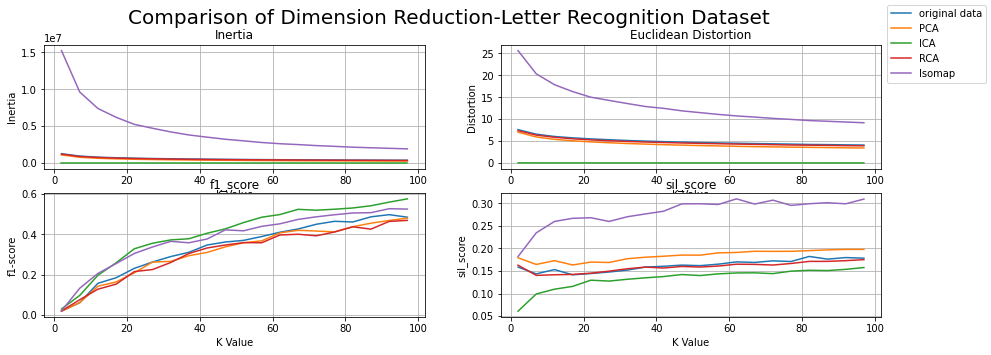

In [482]:
#Kmeans Letter Recognition
fig, ax = plt.subplots(2, 2, figsize=(15, 5))

ax[0,0].plot(range_n_clusters,inertia_km_lrecog, label='original data')
ax[0,0].plot(range_n_clusters,inertia_km_lrecog_PCA, label='PCA')
ax[0,0].plot(range_n_clusters,inertia_km_lrecog_ICA, label='ICA')
ax[0,0].plot(range_n_clusters,inertia_km_lrecog_RCA, label='RCA')
ax[0,0].plot(range_n_clusters,inertia_km_lrecog_isomap, label='Isomap')
ax[0,0].set_xlabel('K Value')
ax[0,0].set_ylabel('Inertia')
ax[0,0].set_title('Inertia')
ax[0,0].grid()


ax[0,1].plot(range_n_clusters,distortions_km_lrecog)
ax[0,1].plot(range_n_clusters,distortions_km_lrecog_PCA)
ax[0,1].plot(range_n_clusters,distortions_km_lrecog_ICA)
ax[0,1].plot(range_n_clusters,distortions_km_lrecog_RCA)
ax[0,1].plot(range_n_clusters,distortions_km_lrecog_isomap)
ax[0,1].set_xlabel('K Value')
ax[0,1].set_ylabel('Distortion')
ax[0,1].set_title('Euclidean Distortion')
ax[0,1].grid()


ax[1,0].plot(range_n_clusters,f1_scores_km_lrecog)
ax[1,0].plot(range_n_clusters,f1_scores_km_lrecog_PCA)
ax[1,0].plot(range_n_clusters,f1_scores_km_lrecog_ICA)
ax[1,0].plot(range_n_clusters,f1_scores_km_lrecog_RCA)
ax[1,0].plot(range_n_clusters,f1_scores_km_lrecog_isomap)
ax[1,0].set_xlabel('K Value')
ax[1,0].set_ylabel('f1-score')
ax[1,0].set_title('f1_score')
ax[1,0].grid()

ax[1,1].plot(range_n_clusters,sil_scores_km_lrecog)
ax[1,1].plot(range_n_clusters,sil_scores_km_lrecog_PCA)
ax[1,1].plot(range_n_clusters,sil_scores_km_lrecog_ICA)
ax[1,1].plot(range_n_clusters,sil_scores_km_lrecog_RCA)
ax[1,1].plot(range_n_clusters,sil_scores_km_lrecog_isomap)
ax[1,1].set_xlabel('K Value')
ax[1,1].set_ylabel('sil_score')
ax[1,1].set_title('sil_score')
ax[1,1].grid()
fig.legend()
fig.suptitle('Comparison of Dimension Reduction-Letter Recognition Dataset', fontsize=20)
plt.show()

### ANN with PCA

In [518]:
f1_score_test_DR_list_inner=[]
elaped_time_list_inner=[]
for i in range(10):
    # X_train_adult, X_test_adult, y_train_adult, y_test_adult
    X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(X_adult, y_adult, test_size=0.2, random_state=20+2*i)

    clf = MLPClassifier(hidden_layer_sizes=(10,2,), solver='adam', activation='logistic', 
                        learning_rate_init=0.1, max_iter=10000, early_stopping = False, random_state=22955+2*i*25)
    start = time.time()
    clf.fit(X_train_adult, y_train_adult)
    end = time.time()

    y_pred_test = clf.predict(X_test_adult)
    y_pred_train = clf.predict(X_train_adult)
    f1_score_test = f1_score(y_test_adult, y_pred_test)
    elaped_time = end-start
    f1_score_test_DR_list_inner.append(f1_score_test)
    elaped_time_list_inner.append(elaped_time)

In [519]:
f1_score_test_DR_list =[]
elaped_time_list =[]
f1_score_test_DR_list.append(np.mean(f1_score_test_DR_list_inner))
elaped_time_list.append(np.mean(elaped_time_list_inner))
for variance in [0.5,0.6,0.7,0.8,0.9]: 
    f1_score_test_DR_list_inner=[]
    elaped_time_list_inner=[]
    for i in range(10):
        pca=PCA(variance,random_state=22955+i*100)
        X_adult_DR=pca.fit_transform(X_adult) 

        X_train_adult_DR, X_test_adult_DR, y_train_adult_DR, y_test_adult_DR = train_test_split(X_adult_DR, y_adult, test_size=0.2, random_state=20+i*100)

        clf = MLPClassifier(hidden_layer_sizes=(10,2,), solver='adam', activation='logistic', 
                            learning_rate_init=0.1, max_iter=1000, early_stopping = False, random_state=22955)
        start = time.time()
        clf.fit(X_train_adult_DR, y_train_adult_DR)
        end = time.time()
        y_pred_test_DR = clf.predict(X_test_adult_DR)
        y_pred_train_DR = clf.predict(X_train_adult_DR)
        f1_score_test_DR_list_inner.append(f1_score(y_test_adult_DR, y_pred_test_DR))
        elaped_time_list_inner.append(end-start)
        
    f1_score_test_DR_list.append(np.mean(f1_score_test_DR_list_inner))
    elaped_time_list.append(np.mean(elaped_time_list_inner))

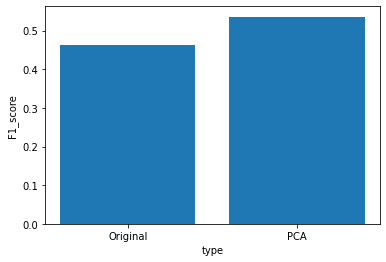

In [485]:
plt.bar(['Original','PCA'], [f1_score_test,f1_score_test_DR])
plt.xlabel('type')
plt.ylabel('F1_score')
plt.show()

In [493]:
f1_score_test_DR_list

[0.4635761589403974,
 0.42201834862385323,
 0.5161290322580645,
 0.532608695652174,
 0.5359477124183006]

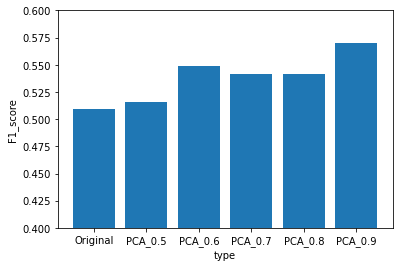

In [530]:
plt.bar(['Original','PCA_0.5','PCA_0.6','PCA_0.7','PCA_0.8','PCA_0.9'], f1_score_test_DR_list)
plt.xlabel('type')
plt.ylabel('F1_score')
plt.ylim(0.4,0.6)
plt.show()

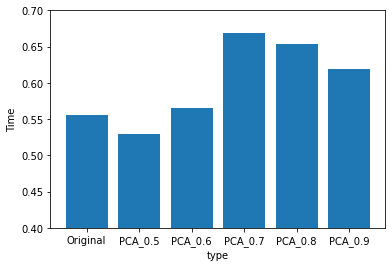

In [528]:
plt.bar(['Original','PCA_0.5','PCA_0.6','PCA_0.7','PCA_0.8','PCA_0.9'], elaped_time_list)
plt.xlabel('type')
plt.ylabel('Time')
plt.ylim(0.4,0.7)
plt.show()

In [ ]:
f1_score_test_list = []
for i in range(1000):
    clf = MLPClassifier(hidden_layer_sizes=(10,2,), solver='adam', activation='logistic', 
                    learning_rate_init=0.01, max_iter=i+1, early_stopping = True, random_state=22955)
    clf.fit(X_train_adult, y_train_adult)
    y_pred_test = clf.predict(X_test_adult)
    y_pred_train = clf.predict(X_train_adult)
    f1_score_test_list.append(f1_score(y_test_adult, y_pred_test))
    

In [ ]:
f1_score_test_DR_list = []
for i in range(1000):
    clf = MLPClassifier(hidden_layer_sizes=(10,2,), solver='adam', activation='logistic', 
                        learning_rate_init=0.01, max_iter=i+1, early_stopping = True, random_state=22955)
    clf.fit(X_train_adult_DR, y_train_adult_DR)
    y_pred_test_DR = clf.predict(X_test_adult_DR)
    y_pred_train_DR = clf.predict(X_train_adult_DR)
    f1_score_test_DR_list.append(f1_score(y_test_adult_DR, y_pred_test_DR))

In [ ]:
plt.plot(f1_score_test_list, label ='original')
plt.plot(f1_score_test_DR_list, label ='PCA')
plt.xlabel('iteration')
plt.ylabel('f1_score')
plt.legend()
plt.show()

### ANN with Kmeans

In [523]:

k_means_model = KMeans(n_clusters=50, random_state=22955).fit(X_adult)
k_means_model.fit(X_adult)
len(k_means_model.labels_)


2000

In [524]:
np.c_[ X_adult, k_means_model.labels_ ].shape

(2000, 69)

In [526]:

f1_score_test_kmeans_list =[]
X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(X_adult, y_adult, test_size=0.2, random_state=20)
clf.fit(X_train_adult, y_train_adult)
y_pred_test = clf.predict(X_test_adult)
y_pred_train = clf.predict(X_train_adult)
f1_score_test_kmeans_list.append(f1_score(y_test_adult, y_pred_test))




for k in [5,20,30,40,50]:
    f1_score_test_kmeans_list_inner=[]
    for i in range(10):
        k_means_model = KMeans(n_clusters=k, random_state=22955*i).fit(X_adult)
        k_means_model.fit(X_adult)
        X_adult_new = np.c_[ X_adult, k_means_model.labels_ ]

        X_train_adult_new, X_test_adult_new, y_train_adult_new, y_test_adult_new = train_test_split(X_adult_new, y_adult, test_size=0.2, random_state=20*i)


        clf = MLPClassifier(hidden_layer_sizes=(10,2,), solver='adam', activation='logistic', 
                            learning_rate_init=0.1, max_iter=500, early_stopping = False, random_state=22955*i)

        clf.fit(X_train_adult_new, y_train_adult_new)
        y_pred_test_new = clf.predict(X_test_adult_new)
        y_pred_train_new = clf.predict(X_train_adult_new)
        f1_score_test_kmeans_list_inner.append(f1_score(y_test_adult_new, y_pred_test_new)) 
    f1_score_test_kmeans_list.append(np.mean(f1_score_test_kmeans_list_inner))


In [488]:
f1_score_test_kmeans_list

[0.4635761589403974,
 0.573170731707317,
 0.5165562913907286,
 0.47058823529411764,
 0.5842696629213483,
 0.5419354838709677]

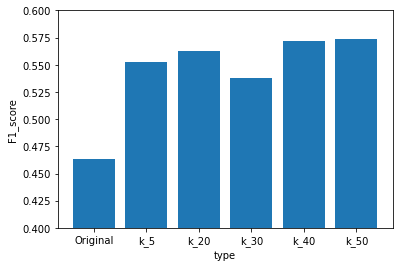

In [533]:
plt.bar(['Original','k_5','k_20','k_30','k_40','k_50'], f1_score_test_kmeans_list)
plt.xlabel('type')
plt.ylabel('F1_score')
plt.ylim(0.4,0.6)
plt.show()